# Gap choosing model

In [1]:
import peptides
import numpy as np
import pandas as pd
from datetime import date
import seaborn as sns
from math import sqrt
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import datetime

# libs for ml
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import classification_report
from sklearn.manifold import TSNE
from sklearn.utils import shuffle
from scipy.stats import entropy
#from umap import UMAP

# my module with some func
import pepcode
from tg_bot_notification import telegram_logger

## Set Parameters:

In [2]:
start_time = datetime.datetime.now()
AA_LIST = pepcode.AA_LIST

latent_dims = 200
num_epochs = 200
batch_size = 400
learning_rate = 1e-4 
use_gpu = True

# Device set
if use_gpu and torch.cuda.is_available():
    device = torch.device("cuda:0")
elif use_gpu and torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

## Preparing data

In [3]:
data = pd.read_csv('./dataset/vdjdb-2024-11-27-fixed/vdjdb.slim.txt', sep = '\t')
data = data[(data.gene == 'TRB') & (data.species == 'HomoSapiens')]
data.reset_index(drop=True, inplace=True)

# Filter cdr3 with 10<len<20 and stars with 'C' and ends with 'F' or 'W'
index_list = []
for i in range(len(data)):
    if len(data.iloc[i].cdr3)>10 and len(data.iloc[i].cdr3)<20 and data.iloc[i].cdr3[0]=='C' and (data.iloc[i].cdr3[-1]=='F' or data.iloc[i].cdr3[-1]=='W'):
        continue
    else:
        index_list.append(i)
data.drop(index=index_list, inplace=True)
data = shuffle(data)
data.reset_index(drop=True, inplace=True)

# Split dataset and prepare train, test, evaluation datasets
train_size, test_size, eval_size = int(round(len(data)*0.7, 0)), int(round(len(data)*(0.7+0.15), 0)), int(round(len(data)*(1), 0))
data_split = np.split(data, [train_size, test_size, eval_size], axis=0)
data_train = data_split[0]
data_test = data_split[1]
data_eval = data_split[2]

# Prepare peptide lists
pep_train_list_ori = data_train.cdr3.values
pep_test_list_ori = data_test.cdr3.values
pep_eval_list_ori = data_eval.cdr3.values

# Gap insertion
pep_train_list = []
for seq in pep_train_list_ori:
    gap_count = 19-len(seq) # Т.к. у нас максимум 19
    pep_train_list.append(seq[0:3]+'-'*gap_count+seq[3:])
    pep_train_list.append(seq[0:4]+'-'*gap_count+seq[4:])
    pep_train_list.append(seq[0:-3]+'-'*gap_count+seq[-3:])
    pep_train_list.append(seq[0:-4]+'-'*gap_count+seq[-4:])
    
pep_test_list = []
for seq in pep_test_list_ori:
    gap_count = 19-len(seq) # Т.к. у нас максимум 19
    pep_test_list.append(seq[0:3]+'-'*gap_count+seq[3:])
    pep_test_list.append(seq[0:4]+'-'*gap_count+seq[4:])
    pep_test_list.append(seq[0:-3]+'-'*gap_count+seq[-3:])
    pep_test_list.append(seq[0:-4]+'-'*gap_count+seq[-4:])

pep_eval_list = []
for seq in pep_eval_list_ori:
    gap_count = 19-len(seq) # Т.к. у нас максимум 19
    pep_eval_list.append(seq[0:3]+'-'*gap_count+seq[3:])
    pep_eval_list.append(seq[0:4]+'-'*gap_count+seq[4:])
    pep_eval_list.append(seq[0:-3]+'-'*gap_count+seq[-3:])
    pep_eval_list.append(seq[0:-4]+'-'*gap_count+seq[-4:])


len_seq = len(pep_train_list[0])


pep_train_oh = np.zeros((len(pep_train_list), len(pepcode.AA_LIST), len_seq), dtype = np.float32)
for i in range(len(pep_train_oh)):
    pep_train_oh[i] = pepcode.one_hot_code(pep_train_list[i])

pep_test_oh = np.zeros((len(pep_test_list), len(pepcode.AA_LIST), len_seq), dtype = np.float32)
for i in range(len(pep_test_list)):
    pep_test_oh[i] = pepcode.one_hot_code(pep_test_list[i])  

pep_eval_oh = np.zeros((len(pep_eval_list), len(pepcode.AA_LIST), len_seq), dtype = np.float32)
for i in range(len(pep_eval_list)):
    pep_eval_oh[i] = pepcode.one_hot_code(pep_eval_list[i])  



oh_matr_size = pep_test_oh[0].size


# Prepare train dataloader
oh_dataset_train = torch.utils.data.TensorDataset(torch.tensor(pep_train_oh), torch.tensor(np.ones(pep_train_oh.shape[0])))
oh_train_dl = torch.utils.data.DataLoader(oh_dataset_train, batch_size=batch_size, shuffle=False)

# Prepare test dataloader
oh_dataset_test = torch.utils.data.TensorDataset(torch.tensor(pep_test_oh), torch.tensor(np.ones(pep_test_oh.shape[0])))
oh_test_dl = torch.utils.data.DataLoader(oh_dataset_test, batch_size=batch_size, shuffle=False)

# Evaluation (пока не нужно)
oh_dataset_eval = torch.utils.data.TensorDataset(torch.tensor(pep_eval_oh), torch.tensor(np.ones(pep_eval_oh.shape[0])))
oh_eval_dl = torch.utils.data.DataLoader(oh_dataset_eval, batch_size=batch_size, shuffle=False)

/Users/alex/miniconda3/envs/tcreppred_sil2/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


## Autoencoder definition (MSELoss)

In [4]:
autoencoder_arch = f'{oh_matr_size}->{latent_dims}'

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(in_features=len(AA_LIST)*len_seq, out_features=latent_dims)
        )
        self.decoder = nn.Sequential(
            nn.Linear(in_features=latent_dims, out_features=len(AA_LIST)*len_seq),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

    def encoding(self, x):
        encoded = self.encoder(x)
        return encoded

    def decoding(self, encoded):
        decoded = self.decoder(encoded)
        return decoded
    
autoencoder = Autoencoder()
autoencoder = autoencoder.to(device)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(autoencoder.parameters(), lr = learning_rate)

### Train autoencoder (MSELoss)

In [5]:
autoencoder.train()

train_loss_avg = []

print('Training ...')
for epoch in range(num_epochs):
    train_loss_avg.append(0)
    num_batches = 0
    
    for pep_batch, _ in oh_train_dl:
        
        pep_batch = pep_batch.to(device)
        pep_batch = pep_batch.reshape(-1, oh_matr_size)
        
        # autoencoder reconstruction
        pep_batch_recon = autoencoder(pep_batch)
        
        # reconstruction error
        loss = loss_function(pep_batch_recon, pep_batch)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss_avg[-1] += loss.item()
        num_batches += 1
        
    train_loss_avg[-1] /= num_batches
    if epoch % 40 == 0:
        print('Epoch [%d / %d] average reconstruction error: %f' % (epoch+1, num_epochs, train_loss_avg[-1]))
print('Train finished')

Training ...
Epoch [1 / 200] average reconstruction error: 0.096880
Epoch [41 / 200] average reconstruction error: 0.000558
Epoch [81 / 200] average reconstruction error: 0.000049
Epoch [121 / 200] average reconstruction error: 0.000015
Epoch [161 / 200] average reconstruction error: 0.000005
Train finished


### Evaluation on test set (MSELoss)

In [6]:
autoencoder.eval()

output = []
test_loss_avg_1, num_batches = 0, 0

for (pep, _) in oh_test_dl:
    with torch.no_grad():
        pep = pep.reshape(-1, oh_matr_size)
        pep = pep.to(device)
        pep_recon = autoencoder(pep)
        loss = loss_function(pep_recon, pep)
        test_loss_avg_1 += loss.item()
        num_batches += 1
    output.append((pep, pep_recon))
test_loss_avg_1 /= num_batches


test_loss_avg_1 /= num_batches
print('Average reconstruction error: %f' % (test_loss_avg_1))

# Output выглядит странно это лист, состоящий из кортежей, каждый из которых относится к одному батчу. Т.е. ouput[0] - это кортеж из первого батча
# Далее каждый кортеж, состоит из двух тензоров: до и после энкодера. Тензоры в 2д формате.


# Создаём пустые(нулевые) массивы для one-hot петпидов до и после
pep_test_oh_bef = np.zeros((len(pep_test_list), len(pepcode.AA_LIST), len_seq), dtype = np.float32)
pep_test_oh_aft = np.zeros((len(pep_test_list), len(pepcode.AA_LIST), len_seq), dtype = np.float32)


# Переводим пептиды в np массив из output
pointer = 0
for i in range(num_batches):
    cur_batch_size = len(output[i][0])
    pep_test_oh_bef[pointer:pointer + cur_batch_size, :, : ] = output[i][0].reshape((cur_batch_size, len(AA_LIST), len_seq)).numpy(force=True)
    pep_test_oh_aft[pointer:pointer + cur_batch_size, :, : ] = output[i][1].reshape((cur_batch_size, len(AA_LIST), len_seq)).numpy(force=True)
    pointer += cur_batch_size
    
pep_test_list_bef_ae = []
pep_test_list_aft_ae = []

for i in range(pep_test_oh_aft.shape[0]):
    pep_test_list_bef_ae.append(pepcode.one_hot_decode(pep_test_oh_bef[i], mode = 'entropy', entropy_threshold = 2.5))  
    pep_test_list_aft_ae.append(pepcode.one_hot_decode(pep_test_oh_aft[i], mode = 'entropy', entropy_threshold = 2.5))

Average reconstruction error: 0.000000


### Biological evaluatiuon (MSELoss)

In [7]:
err_count = np.zeros(len_seq, dtype = np.float32)
blos_score = np.zeros(len_seq, dtype = np.float32)
err_dict = {}
gap_dict_before = {key: 0 for key in range(len_seq)}
gap_dict_after = {key: 0 for key in range(len_seq)}


for i in range(len(pep_test_list_bef_ae)):
    for j in range(len_seq):
        aa_before = pep_test_list_bef_ae[i][j]
        aa_after = pep_test_list_aft_ae[i][j]
        #Errors count
        if aa_before != aa_after:
            err_count[j] +=1
            if aa_before+aa_after in err_dict.keys():
                err_dict[aa_before+aa_after] += 1
            else:
                err_dict[aa_before+aa_after] = 1
        #Gaps count
        if pep_test_list_bef_ae[i][j] == '-':
            gap_dict_before[j] += 1
        if pep_test_list_aft_ae[i][j] == '-':
            gap_dict_after[j] += 1

err_dict = dict(sorted(err_dict.items(), key=lambda item: item[1]))

# For classification report only
pep_test_list_bef_ae_aa = []
pep_test_list_aft_ae_aa = []
for i in range(len(pep_test_list_bef_ae)):
    for j in pep_test_list_bef_ae[i]:
        pep_test_list_bef_ae_aa.append(j)
    for k in pep_test_list_aft_ae[i]:
        pep_test_list_aft_ae_aa.append(k)

#### Gap distribution (MSELoss)

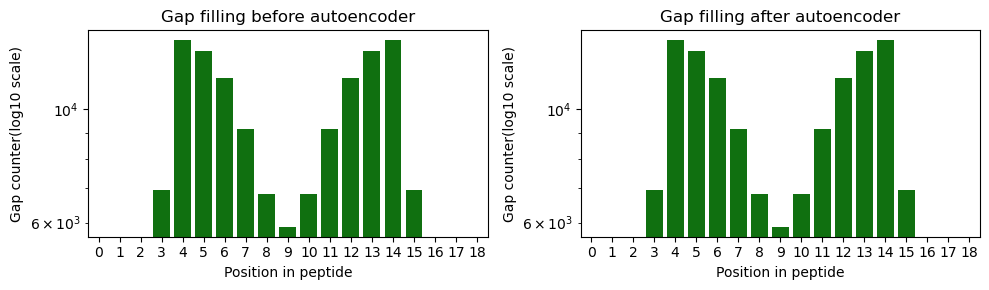

In [8]:
fig, axs = plt.subplots(1, 2,  figsize = [10, 3])
sns.barplot(gap_dict_before, color = 'green', ax=axs[0])
axs[0].set_yscale("log")
sns.barplot(gap_dict_after, color = 'green', ax=axs[1])
axs[1].set_yscale("log")
axs[0].set(title='Gap filling before autoencoder', xlabel='Position in peptide', ylabel='Gap counter(log10 scale)')
axs[1].set(title='Gap filling after autoencoder', xlabel='Position in peptide', ylabel='Gap counter(log10 scale)')
plt.tight_layout()
plt.show()

#### Aminoacid changes (MSELoss)

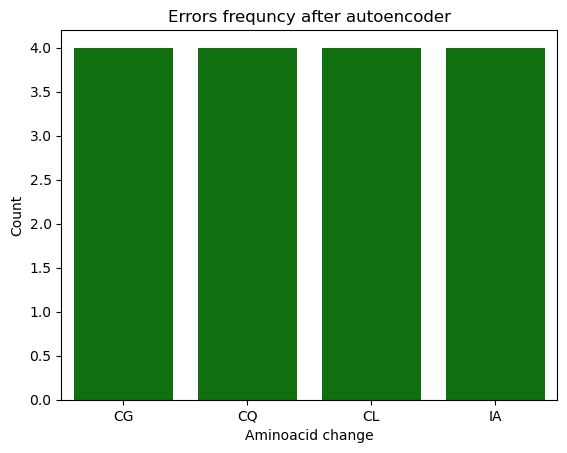

In [9]:
errors_freq = 3 #by quantity

err_dict_hf = {}
for i in err_dict.keys():
    if err_dict[i] > errors_freq:
        err_dict_hf[i] = err_dict[i]

sns.barplot(err_dict_hf, color = 'green')
plt.title('Errors frequncy after autoencoder')
plt.xlabel('Aminoacid change')
plt.ylabel('Count')
plt.show()

#### Main report (MSELoss)

/Users/alex/miniconda3/envs/tcreppred_sil2/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/alex/miniconda3/envs/tcreppred_sil2/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/alex/miniconda3/envs/tcreppred_sil2/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitaliz

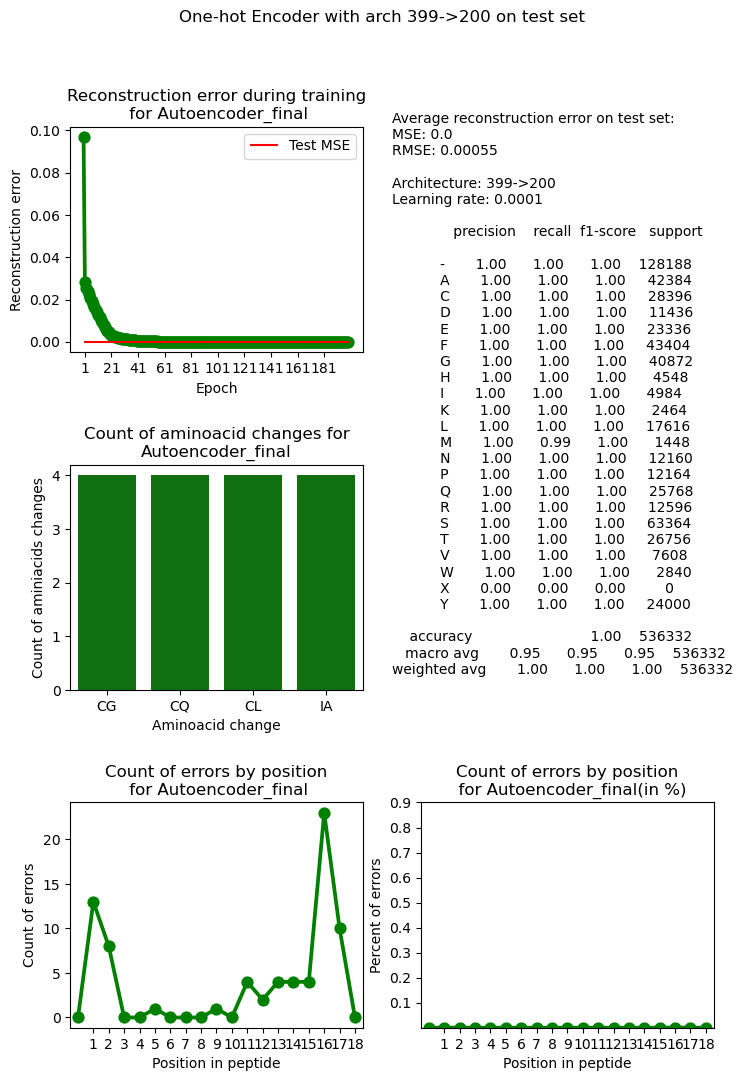

In [10]:
fig, axs = plt.subplots(3,2, figsize = [8.3, 11.7])

sns.pointplot(train_loss_avg , color = 'green', ax=axs[0, 0])
sns.barplot(err_dict_hf, color = 'green', ax=axs[1, 0])
sns.pointplot(err_count, color = 'green', ax=axs[2, 0])
sns.pointplot(err_count/len(pep_test_list_bef_ae), color = 'green', ax=axs[2, 1])

axs[0, 0].hlines(round(test_loss_avg_1, 5), 0, num_epochs, color = 'red', label='Test MSE')
axs[0, 0].legend()
axs[0, 0].set(xlabel='Epoch', ylabel='Reconstruction error', title = f'Reconstruction error during training\n for Autoencoder_final', xticks=[i for i in range(1, num_epochs, int(num_epochs/10))])
axs[0, 1].set(frame_on=False)
axs[0, 1].set_xticks([])
axs[0, 1].set_yticks([])
axs[0, 1].text(x=-0.1, y=-1.5, s=f'Average reconstruction error on test set:\nMSE: {round(test_loss_avg_1, 5)}\nRMSE: {round(sqrt(test_loss_avg_1), 5)}\n\nArchitecture: {autoencoder_arch}\nLearning rate: {learning_rate}\n\n{classification_report(pep_test_list_bef_ae_aa, pep_test_list_aft_ae_aa)}')
axs[1, 0].set(xlabel='Aminoacid change', ylabel='Count of aminiacids changes', title=f'Count of aminoacid changes for\nAutoencoder_final')
axs[1, 1].set(frame_on=False)
axs[1, 1].set_xticks([])
axs[1, 1].set_yticks([])
axs[2, 0].set(xlabel='Position in peptide', ylabel='Count of errors', title=f'Count of errors by position\n for Autoencoder_final')
axs[2, 1].set(xlabel='Position in peptide', ylabel='Percent of errors', title=f'Count of errors by position\n  for Autoencoder_final(in %)', yticks=[i/10 for i in range(1, 10)])
axs[2, 0].set_xticks([i for i in range(1, len_seq, int(len_seq/10))])
axs[2, 1].set_xticks([i for i in range(1, len_seq, int(len_seq/10))])


plt.subplots_adjust(wspace=0.2, hspace=0.5)
fig.suptitle(f'One-hot Encoder with arch {autoencoder_arch} on test set') 
plt.show()
#fig.savefig(f'./Results_one_hot/{str(date.today())}_final_{autoencoder_arch}_on_test.pdf', format='pdf')

## Autoencoder definition (CustomLoss)

In [11]:
autoencoder_arch = f'{oh_matr_size}->{latent_dims}'

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(in_features=len(AA_LIST)*len_seq, out_features=latent_dims)
        )
        self.decoder = nn.Sequential(
            nn.Linear(in_features=latent_dims, out_features=len(AA_LIST)*len_seq),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

    def encoding(self, x):
        encoded = self.encoder(x)
        return encoded

    def decoding(self, encoded):
        decoded = self.decoder(encoded)
        return decoded
    
autoencoder = Autoencoder()
autoencoder = autoencoder.to(device)

optimizer = torch.optim.Adam(autoencoder.parameters(), lr = learning_rate)

### Custom loss function definition

In [12]:
def custom_loss(inp, target):
    # Считаем loss для матриц целиком и берем среднее по строкам (отдельным векторам)
    mse_loss = F.mse_loss(inp, target, reduction='none').mean(dim=1)
    # Rescaling для вида (batch_size/4, 4)
    mse_loss = mse_loss.view(-1, 4)
    # В каждой четверке выбираем индекс максимального элемента
    embd_max_loss = mse_loss.argmax(dim=1)
    # Делаем клон элемента, чтобы не портить сам вектор
    inp_clone = inp.clone()#.detach()
    # Создаем вектор из нулей размером batch_size
    indices = torch.zeros(inp.shape[0], device=inp.device, dtype=int)
    # Переводим indices в формат (batch_size/4, 4) добавляем максимальные индексы в формате столбца (broadcasting сделаем, что все 4 буду одинаковы). B снова переводим в строку
    indices = (indices.view(-1, 4) + embd_max_loss.view(-1, 1)).view(-1)
    # Клониируем
    inp_clone = inp[indices]
    return F.mse_loss(inp_clone, target)

### Train autoencoder (CustomLoss)

In [13]:
autoencoder.train()

train_loss_avg = []

print('Training ...')
for epoch in range(num_epochs):
    train_loss_avg.append(0)
    num_batches = 0
    
    for pep_batch, _ in oh_train_dl:
        
        pep_batch = pep_batch.to(device)
        pep_batch = pep_batch.reshape(-1, oh_matr_size)
        
        # autoencoder reconstruction
        pep_batch_recon = autoencoder(pep_batch)
        
        # reconstruction error
        loss = custom_loss(pep_batch_recon, pep_batch)
        
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss_avg[-1] += loss.item()
        num_batches += 1
        
    train_loss_avg[-1] /= num_batches
    if epoch % 40 == 0:
        print('Epoch [%d / %d] average reconstruction error: %f' % (epoch+1, num_epochs, train_loss_avg[-1]))
print('Train finished')

Training ...
Epoch [1 / 200] average reconstruction error: 0.119193
Epoch [41 / 200] average reconstruction error: 0.030135
Epoch [81 / 200] average reconstruction error: 0.030126
Epoch [121 / 200] average reconstruction error: 0.030121
Epoch [161 / 200] average reconstruction error: 0.030117
Train finished


### Evaluation on test set (CustomLoss)

In [14]:
autoencoder.eval()

output = []
test_loss_avg_1, num_batches = 0, 0

for (pep, _) in oh_test_dl:
    with torch.no_grad():
        pep = pep.reshape(-1, oh_matr_size)
        pep = pep.to(device)
        pep_recon = autoencoder(pep)
        loss = custom_loss(pep_batch_recon, pep_batch)
        test_loss_avg_1 += loss.item()
        num_batches += 1
    output.append((pep, pep_recon))
test_loss_avg_1 /= num_batches


test_loss_avg_1 /= num_batches
print('Average reconstruction error: %f' % (test_loss_avg_1))

# Output выглядит странно это лист, состоящий из кортежей, каждый из которых относится к одному батчу. Т.е. ouput[0] - это кортеж из первого батча
# Далее каждый кортеж, состоит из двух тензоров: до и после энкодера. Тензоры в 2д формате.


# Создаём пустые(нулевые) массивы для one-hot петпидов до и после
pep_test_oh_bef = np.zeros((len(pep_test_list), len(pepcode.AA_LIST), len_seq), dtype = np.float32)
pep_test_oh_aft = np.zeros((len(pep_test_list), len(pepcode.AA_LIST), len_seq), dtype = np.float32)


# Переводим пептиды в np массив из output
pointer = 0
for i in range(num_batches):
    cur_batch_size = len(output[i][0])
    pep_test_oh_bef[pointer:pointer + cur_batch_size, :, : ] = output[i][0].reshape((cur_batch_size, len(AA_LIST), len_seq)).numpy(force=True)
    pep_test_oh_aft[pointer:pointer + cur_batch_size, :, : ] = output[i][1].reshape((cur_batch_size, len(AA_LIST), len_seq)).numpy(force=True)
    pointer += cur_batch_size
    
pep_test_list_bef_ae = []
pep_test_list_aft_ae = []

for i in range(pep_test_oh_aft.shape[0]):
    pep_test_list_bef_ae.append(pepcode.one_hot_decode(pep_test_oh_bef[i], mode = 'entropy', entropy_threshold = 2.5))  
    pep_test_list_aft_ae.append(pepcode.one_hot_decode(pep_test_oh_aft[i], mode = 'entropy', entropy_threshold = 2.5))

Average reconstruction error: 0.000414


### Biological evaluatiuon (CustomLoss)

In [15]:
err_count = np.zeros(len_seq, dtype = np.float32)
blos_score = np.zeros(len_seq, dtype = np.float32)
err_dict = {}
gap_dict_before = {key: 0 for key in range(len_seq)}
gap_dict_after = {key: 0 for key in range(len_seq)}


for i in range(len(pep_test_list_bef_ae)):
    for j in range(len_seq):
        aa_before = pep_test_list_bef_ae[i][j]
        aa_after = pep_test_list_aft_ae[i][j]
        #Errors count
        if aa_before != aa_after:
            err_count[j] +=1
            if aa_before+aa_after in err_dict.keys():
                err_dict[aa_before+aa_after] += 1
            else:
                err_dict[aa_before+aa_after] = 1
        #Gaps count
        if aa_before == '-':
            gap_dict_before[j] += 1
        if aa_after == '-':
            gap_dict_after[j] += 1

err_dict = dict(sorted(err_dict.items(), key=lambda item: item[1]))

# For classification report only
pep_test_list_bef_ae_aa = []
pep_test_list_aft_ae_aa = []
for i in range(len(pep_test_list_bef_ae)):
    for j in pep_test_list_bef_ae[i]:
        pep_test_list_bef_ae_aa.append(j)
    for k in pep_test_list_aft_ae[i]:
        pep_test_list_aft_ae_aa.append(k)

#### Gap distribution (CustomLoss)

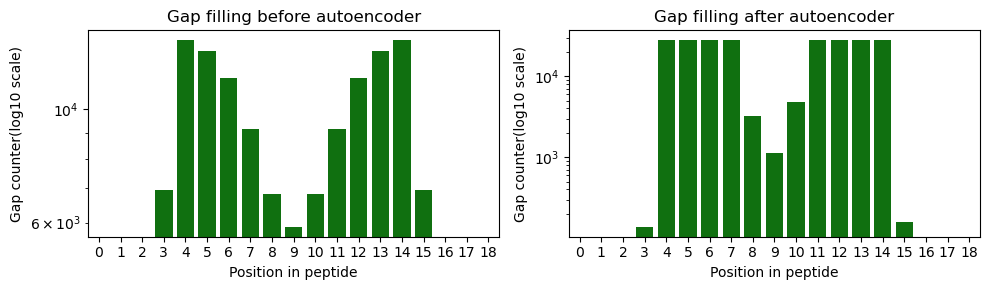

In [16]:
fig, axs = plt.subplots(1, 2,  figsize = [10, 3])
sns.barplot(gap_dict_before, color = 'green', ax=axs[0])
axs[0].set_yscale("log")
sns.barplot(gap_dict_after, color = 'green', ax=axs[1])
axs[1].set_yscale("log")
axs[0].set(title='Gap filling before autoencoder', xlabel='Position in peptide', ylabel='Gap counter(log10 scale)')
axs[1].set(title='Gap filling after autoencoder', xlabel='Position in peptide', ylabel='Gap counter(log10 scale)')
plt.tight_layout()
plt.show()

#### Aminoacid changes (CustomLoss)

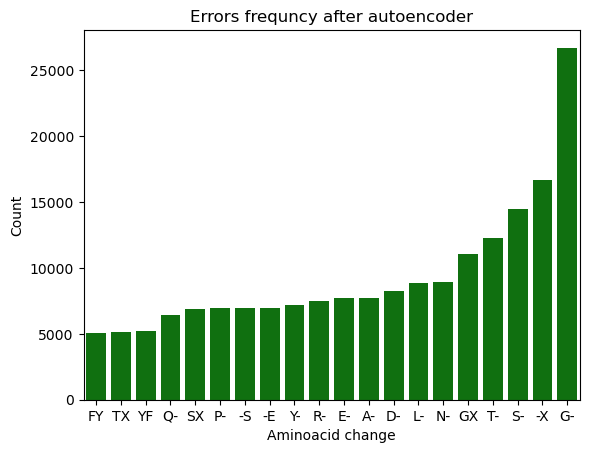

In [17]:
errors_freq = 5000 #by quantity

err_dict_hf = {}
for i in err_dict.keys():
    if err_dict[i] > errors_freq:
        err_dict_hf[i] = err_dict[i]

sns.barplot(err_dict_hf, color = 'green')
plt.title('Errors frequncy after autoencoder')
plt.xlabel('Aminoacid change')
plt.ylabel('Count')
plt.show()

#### Main report (CustomLoss)

/Users/alex/miniconda3/envs/tcreppred_sil2/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/alex/miniconda3/envs/tcreppred_sil2/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/alex/miniconda3/envs/tcreppred_sil2/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{

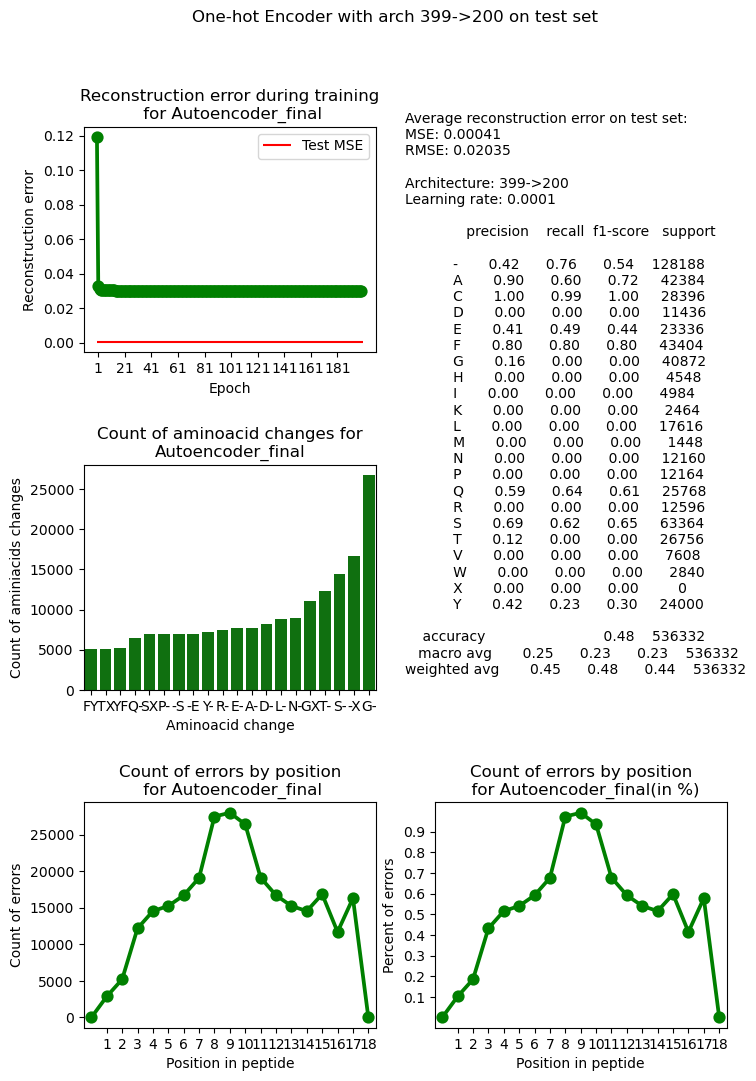

In [18]:
fig, axs = plt.subplots(3,2, figsize = [8.3, 11.7])

sns.pointplot(train_loss_avg , color = 'green', ax=axs[0, 0])
sns.barplot(err_dict_hf, color = 'green', ax=axs[1, 0])
sns.pointplot(err_count, color = 'green', ax=axs[2, 0])
sns.pointplot(err_count/len(pep_test_list_bef_ae), color = 'green', ax=axs[2, 1])

axs[0, 0].hlines(round(test_loss_avg_1, 5), 0, num_epochs, color = 'red', label='Test MSE')
axs[0, 0].legend()
axs[0, 0].set(xlabel='Epoch', ylabel='Reconstruction error', title = f'Reconstruction error during training\n for Autoencoder_final', xticks=[i for i in range(1, num_epochs, int(num_epochs/10))])
axs[0, 1].set(frame_on=False)
axs[0, 1].set_xticks([])
axs[0, 1].set_yticks([])
axs[0, 1].text(x=-0.1, y=-1.5, s=f'Average reconstruction error on test set:\nMSE: {round(test_loss_avg_1, 5)}\nRMSE: {round(sqrt(test_loss_avg_1), 5)}\n\nArchitecture: {autoencoder_arch}\nLearning rate: {learning_rate}\n\n{classification_report(pep_test_list_bef_ae_aa, pep_test_list_aft_ae_aa)}')
axs[1, 0].set(xlabel='Aminoacid change', ylabel='Count of aminiacids changes', title=f'Count of aminoacid changes for\nAutoencoder_final')
axs[1, 1].set(frame_on=False)
axs[1, 1].set_xticks([])
axs[1, 1].set_yticks([])
axs[2, 0].set(xlabel='Position in peptide', ylabel='Count of errors', title=f'Count of errors by position\n for Autoencoder_final')
axs[2, 1].set(xlabel='Position in peptide', ylabel='Percent of errors', title=f'Count of errors by position\n  for Autoencoder_final(in %)', yticks=[i/10 for i in range(1, 10)])
axs[2, 0].set_xticks([i for i in range(1, len_seq, int(len_seq/10))])
axs[2, 1].set_xticks([i for i in range(1, len_seq, int(len_seq/10))])


plt.subplots_adjust(wspace=0.2, hspace=0.5)
fig.suptitle(f'One-hot Encoder with arch {autoencoder_arch} on test set') 
plt.show()
#fig.savefig(f'./Results_one_hot/{str(date.today())}_final_{autoencoder_arch}_on_test.pdf', format='pdf')

## End of notebook

In [19]:
chat_id = 195865048
@telegram_logger(chat_id)
def end_of_notebook(start_time):
    print("This is end!")
    return (datetime.datetime.now() - start_time)

end_of_notebook(start_time)

This is end!


In [27]:
# Считаем какие конкретно замены
gap_counter_dict = {}
for i in range(len(pep_test_list_bef_ae)):
    for j in range(len_seq):
        aa_before = pep_test_list_bef_ae[i][j]
        aa_after = pep_test_list_aft_ae[i][j]
        if (aa_before == '-') ^ (aa_after == '-'):
            if (aa_before + aa_after) in gap_counter_dict.keys():
                gap_counter_dict[aa_before + aa_after] += 1
            else:
                gap_counter_dict[aa_before + aa_after] = 1

In [28]:
gap_counter_dict

{'-S': 6957,
 'S-': 14444,
 'P-': 6932,
 'A-': 7758,
 'D-': 8264,
 'R-': 7480,
 'T-': 12270,
 '-E': 6957,
 'G-': 26719,
 'F-': 2430,
 'H-': 1354,
 'N-': 8911,
 '-X': 16687,
 'M-': 936,
 'Q-': 6462,
 'I-': 2374,
 'E-': 7736,
 'V-': 4474,
 'L-': 8881,
 'Y-': 7218,
 'W-': 1510,
 'K-': 1219,
 'C-': 39,
 '-G': 57}

In [29]:
# Считаем в каких позициях замены
gap_position_counter_dict = {}
for i in range(len(pep_test_list_bef_ae)):
    for j in range(len_seq):
        aa_before = pep_test_list_bef_ae[i][j]
        aa_after = pep_test_list_aft_ae[i][j]
        if (aa_before == '-') ^ (aa_after == '-'):
            if (j) in gap_position_counter_dict.keys():
                gap_position_counter_dict[j] += 1
            else:
                gap_position_counter_dict[j] = 1

In [30]:
gap_position_counter_dict

{3: 7093,
 5: 15240,
 6: 16687,
 7: 18931,
 11: 18982,
 12: 16688,
 13: 15240,
 14: 14538,
 8: 8563,
 4: 14538,
 10: 7943,
 15: 7117,
 9: 6509}

In [39]:
# Посмотрим по сколько гэпов получается после энкодера
pep_test_list_bef_no_gap = []
pep_test_list_aft_no_gap = []
for i in range(0, len(pep_test_list_bef_ae), 4):
    pep_test_list_bef_no_gap.append(pep_test_list_bef_ae[i].replace('-', ''))
    var = []
    var.append(pep_test_list_aft_ae[i].replace('-', ''))
    var.append(pep_test_list_aft_ae[i+1].replace('-', ''))
    var.append(pep_test_list_aft_ae[i+2].replace('-', ''))
    var.append(pep_test_list_aft_ae[i+3].replace('-', ''))
    c = Counter(var)
    pep_test_list_aft_no_gap.append(c.most_common(1)[0][0])

In [46]:
# Посмотрим есть ли разница в длинах cdr
new_seq_lens_dict = {}
for i in range(len(pep_test_list_bef_no_gap)):
    len_before = len(pep_test_list_bef_no_gap[i])
    len_after = len(pep_test_list_aft_no_gap[i])
    if len_before != len_after:
        if (f'{len_before}'+f'{len_after}') in gap_position_counter_dict.keys():
            new_seq_lens_dict[f'{len_before}'+f'-{len_after}'] += 1
        else:
            new_seq_lens_dict[f'{len_before}'+f'-{len_after}'] = 1

In [53]:
new_seq_lens_dict, len(new_seq_lens_dict)

({'17-11': 1,
  '14-11': 1,
  '15-9': 1,
  '15-11': 1,
  '15-10': 1,
  '13-11': 1,
  '18-10': 1,
  '12-9': 1,
  '16-11': 1,
  '12-11': 1,
  '14-10': 1,
  '12-10': 1,
  '13-8': 1,
  '19-11': 1,
  '15-12': 1,
  '13-10': 1,
  '18-11': 1,
  '17-12': 1,
  '15-8': 1,
  '17-10': 1,
  '18-8': 1,
  '19-13': 1,
  '16-10': 1,
  '16-8': 1,
  '14-9': 1,
  '13-9': 1,
  '14-8': 1,
  '17-9': 1,
  '11-10': 1,
  '12-8': 1,
  '15-13': 1,
  '19-12': 1,
  '18-9': 1,
  '16-9': 1,
  '18-12': 1,
  '17-8': 1,
  '16-12': 1,
  '11-8': 1,
  '17-13': 1,
  '13-7': 1,
  '19-8': 1,
  '19-10': 1,
  '19-9': 1,
  '13-12': 1,
  '18-13': 1,
  '11-9': 1,
  '15-7': 1,
  '14-13': 1,
  '14-7': 1,
  '17-7': 1,
  '11-12': 1,
  '14-12': 1},
 52)

In [52]:
len(pep_test_list_aft_no_gap)

7057

#### Biological evaluation for cdr3 without gaps

In [56]:

#err_count_no_gap = np.zeros(len_seq, dtype = np.float32) # Здесь от него нет смысла
err_dict_no_gap = {}
gap_dict_before_no_gap = {key: 0 for key in range(len_seq)}
# For classification report only
pep_test_list_bef_ae_aa_no_gap = []
pep_test_list_aft_ae_aa_no_gap = []

for i in range(len(pep_test_list_bef_no_gap)):
    len_before = len(pep_test_list_bef_no_gap[i])
    len_after = len(pep_test_list_aft_no_gap[i])
    if len_before == len_after:
        for j in range(len_before):
            aa_before = pep_test_list_bef_no_gap[i][j]
            aa_after = pep_test_list_aft_no_gap[i][j]
            #Errors count
            if aa_before != aa_after:
                #err_count_no_gap[j] +=1
                if aa_before+aa_after in err_dict_no_gap.keys():
                    err_dict_no_gap[aa_before+aa_after] += 1
                else:
                    err_dict_no_gap[aa_before+aa_after] = 1
            # For classification report
            pep_test_list_bef_ae_aa_no_gap.append(aa_before)
            pep_test_list_aft_ae_aa_no_gap.append(aa_after)


In [57]:
# Сделаем classification report для сиквенсов, полученных после удаления гэпов.
print(classification_report(pep_test_list_bef_ae_aa_no_gap, pep_test_list_aft_ae_aa_no_gap))

              precision    recall  f1-score   support

           A       0.81      0.65      0.72       266
           C       1.00      0.99      1.00       216
           D       0.00      0.00      0.00        58
           E       0.54      0.76      0.63       152
           F       0.75      0.88      0.81       318
           G       0.00      0.00      0.00       185
           H       0.00      0.00      0.00        19
           I       0.00      0.00      0.00        29
           K       0.00      0.00      0.00        13
           L       0.00      0.00      0.00        74
           M       0.00      0.00      0.00        10
           N       0.00      0.00      0.00        49
           P       0.00      0.00      0.00        39
           Q       0.51      0.80      0.62       138
           R       0.00      0.00      0.00        79
           S       0.62      0.75      0.68       353
           T       0.00      0.00      0.00       132
           V       0.00    

/Users/alex/miniconda3/envs/tcreppred_sil2/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/alex/miniconda3/envs/tcreppred_sil2/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/alex/miniconda3/envs/tcreppred_sil2/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{

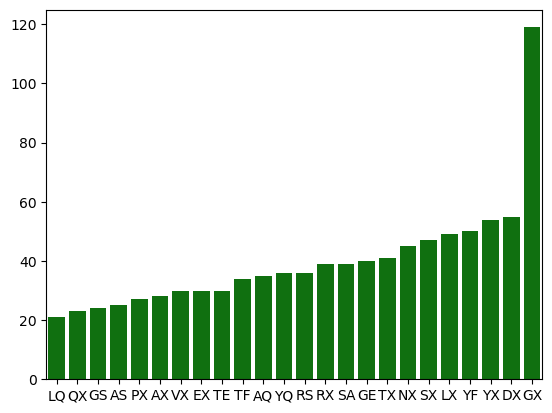

In [61]:
# Какие ошибки он делает. 
# Отберем самые частые (20 и более)
err_dict_no_gap = dict(sorted(err_dict_no_gap.items(), key=lambda item: item[1]))
errors_freq = 20
err_dict_no_gap_hf = {}
for i in err_dict_no_gap.keys():
    if err_dict_no_gap[i] > errors_freq:
        err_dict_no_gap_hf[i] = err_dict_no_gap[i]

sns.barplot(err_dict_no_gap_hf, color = 'green')
plt.show()


### Evaluation on test set (CustomLoss) Entropy choose

In [80]:
autoencoder.eval()

output = []
test_loss_avg_1, num_batches = 0, 0

for (pep, _) in oh_test_dl:
    with torch.no_grad():
        pep = pep.reshape(-1, oh_matr_size)
        pep = pep.to(device)
        pep_recon = autoencoder(pep)
        loss = custom_loss(pep_batch_recon, pep_batch)
        test_loss_avg_1 += loss.item()
        num_batches += 1
    output.append((pep, pep_recon))
test_loss_avg_1 /= num_batches


test_loss_avg_1 /= num_batches
print('Average reconstruction error: %f' % (test_loss_avg_1))

# Output выглядит странно это лист, состоящий из кортежей, каждый из которых относится к одному батчу. Т.е. ouput[0] - это кортеж из первого батча
# Далее каждый кортеж, состоит из двух тензоров: до и после энкодера. Тензоры в 2д формате.


# Создаём пустые(нулевые) массивы для one-hot петпидов до и после
pep_test_oh_bef = np.zeros((len(pep_test_list), len(pepcode.AA_LIST), len_seq), dtype = np.float32)
pep_test_oh_aft = np.zeros((len(pep_test_list), len(pepcode.AA_LIST), len_seq), dtype = np.float32)


# Переводим пептиды в np массив из output
pointer = 0
for i in range(num_batches):
    cur_batch_size = len(output[i][0])
    pep_test_oh_bef[pointer:pointer + cur_batch_size, :, : ] = output[i][0].reshape((cur_batch_size, len(AA_LIST), len_seq)).numpy(force=True)
    pep_test_oh_aft[pointer:pointer + cur_batch_size, :, : ] = output[i][1].reshape((cur_batch_size, len(AA_LIST), len_seq)).numpy(force=True)
    pointer += cur_batch_size
    
pep_test_list_bef_ae = []
pep_test_list_aft_ae = []

for i in range(pep_test_oh_aft.shape[0]):
    pep_test_list_bef_ae.append(pepcode.one_hot_decode(pep_test_oh_bef[i], mode = 'entropy', entropy_threshold = 1.5))  
    pep_test_list_aft_ae.append(pepcode.one_hot_decode(pep_test_oh_aft[i], mode = 'entropy', entropy_threshold = 1.5))

Average reconstruction error: 0.000414


In [81]:
# Считаем какие конкретно замены
gap_counter_dict = {}
for i in range(len(pep_test_list_bef_ae)):
    for j in range(len_seq):
        aa_before = pep_test_list_bef_ae[i][j]
        aa_after = pep_test_list_aft_ae[i][j]
        if (aa_before == '-') ^ (aa_after == '-'):
            if (aa_before + aa_after) in gap_counter_dict.keys():
                gap_counter_dict[aa_before + aa_after] += 1
            else:
                gap_counter_dict[aa_before + aa_after] = 1

In [82]:
gap_position_counter_dict

{3: 7093,
 5: 15240,
 6: 16687,
 7: 18931,
 11: 18982,
 12: 16688,
 13: 15240,
 14: 14538,
 8: 8563,
 4: 14538,
 10: 7943,
 15: 7117,
 9: 6509}

In [83]:
# Посмотрим по сколько гэпов получается после энкодера
pep_test_list_bef_no_gap = []
pep_test_list_aft_no_gap = []
for i in range(0, len(pep_test_list_bef_ae), 4):
    pep_test_list_bef_no_gap.append(pep_test_list_bef_ae[i].replace('-', ''))
    var = []
    var.append(pep_test_list_aft_ae[i].replace('-', ''))
    var.append(pep_test_list_aft_ae[i+1].replace('-', ''))
    var.append(pep_test_list_aft_ae[i+2].replace('-', ''))
    var.append(pep_test_list_aft_ae[i+3].replace('-', ''))
    c = Counter(var)
    pep_test_list_aft_no_gap.append(c.most_common(1)[0][0])

In [84]:
# Посмотрим есть ли разница в длинах cdr
new_seq_lens_dict = {}
for i in range(len(pep_test_list_bef_no_gap)):
    len_before = len(pep_test_list_bef_no_gap[i])
    len_after = len(pep_test_list_aft_no_gap[i])
    if len_before != len_after:
        if (f'{len_before}'+f'{len_after}') in gap_position_counter_dict.keys():
            new_seq_lens_dict[f'{len_before}'+f'-{len_after}'] += 1
        else:
            new_seq_lens_dict[f'{len_before}'+f'-{len_after}'] = 1

In [85]:
new_seq_lens_dict, len(new_seq_lens_dict)

({'17-19': 1,
  '14-19': 1,
  '15-19': 1,
  '11-19': 1,
  '13-19': 1,
  '18-19': 1,
  '12-19': 1,
  '16-19': 1},
 8)

#### Biological evaluation for cdr3 without gaps  Entropy choose

In [86]:

#err_count_no_gap = np.zeros(len_seq, dtype = np.float32) # Здесь от него нет смысла
err_dict_no_gap = {}
gap_dict_before_no_gap = {key: 0 for key in range(len_seq)}
# For classification report only
pep_test_list_bef_ae_aa_no_gap = []
pep_test_list_aft_ae_aa_no_gap = []

for i in range(len(pep_test_list_bef_no_gap)):
    len_before = len(pep_test_list_bef_no_gap[i])
    len_after = len(pep_test_list_aft_no_gap[i])
    if len_before == len_after:
        for j in range(len_before):
            aa_before = pep_test_list_bef_no_gap[i][j]
            aa_after = pep_test_list_aft_no_gap[i][j]
            #Errors count
            if aa_before != aa_after:
                #err_count_no_gap[j] +=1
                if aa_before+aa_after in err_dict_no_gap.keys():
                    err_dict_no_gap[aa_before+aa_after] += 1
                else:
                    err_dict_no_gap[aa_before+aa_after] = 1
            # For classification report
            pep_test_list_bef_ae_aa_no_gap.append(aa_before)
            pep_test_list_aft_ae_aa_no_gap.append(aa_after)


In [87]:
# Сделаем classification report для сиквенсов, полученных после удаления гэпов.
print(classification_report(pep_test_list_bef_ae_aa_no_gap, pep_test_list_aft_ae_aa_no_gap))

              precision    recall  f1-score   support

           A       0.94      0.47      0.62       201
           C       1.00      1.00      1.00       100
           D       0.00      0.00      0.00        59
           E       0.00      0.00      0.00        95
           F       0.85      0.74      0.79       155
           G       0.00      0.00      0.00       220
           H       0.00      0.00      0.00        15
           I       0.00      0.00      0.00        32
           K       0.00      0.00      0.00        10
           L       0.00      0.00      0.00       111
           M       0.00      0.00      0.00         7
           N       0.00      0.00      0.00        68
           P       0.00      0.00      0.00        77
           Q       0.67      0.57      0.61       118
           R       0.00      0.00      0.00        60
           S       0.86      0.34      0.49       287
           T       0.00      0.00      0.00       137
           V       0.00    

/Users/alex/miniconda3/envs/tcreppred_sil2/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/alex/miniconda3/envs/tcreppred_sil2/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/alex/miniconda3/envs/tcreppred_sil2/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{

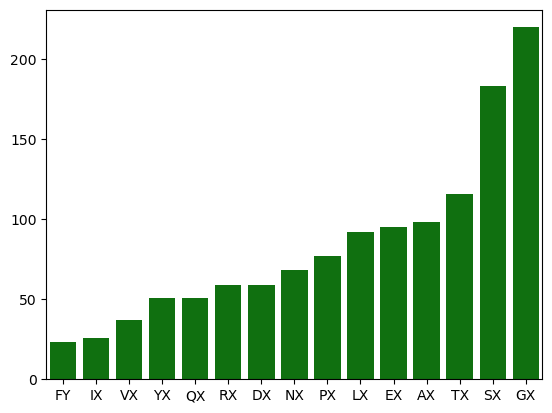

In [88]:
# Какие ошибки он делает. 
# Отберем самые частые (20 и более)
err_dict_no_gap = dict(sorted(err_dict_no_gap.items(), key=lambda item: item[1]))
errors_freq = 20
err_dict_no_gap_hf = {}
for i in err_dict_no_gap.keys():
    if err_dict_no_gap[i] > errors_freq:
        err_dict_no_gap_hf[i] = err_dict_no_gap[i]

sns.barplot(err_dict_no_gap_hf, color = 'green')
plt.show()
